## This notebook will help you train a vanilla Point-Cloud AE with the basic architecture we used in our paper.
    (it assumes latent_3d_points is in the PYTHONPATH and the structural losses have been compiled)

In [33]:
import os
import os.path as osp
import sys

sys.path.append('../..')
from latent_3d_points.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params
from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.point_net_ae import PointNetAutoEncoder

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.tf_utils import reset_tf_graph
from latent_3d_points.src.general_utils import plot_3d_point_cloud

In [34]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# Choose the GPU
os.environ["CUDA_VISIBLE_DEVICES"]='1'

Define Basic Parameters

In [36]:
top_out_dir = '../output/'          # Use to save Neural-Net check-points etc.
top_in_dir = '../../latent_3d_points_data/' # Top-dir of where point-clouds are stored.

class_name_A = 'chair'
class_name_B = 'table'

experiment_name = 'single_class_ae_{}_{}'.format(class_name_A, class_name_B)
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'chamfer'                   # Loss to optimize: 'emd' or 'chamfer'

datafolder = top_in_dir + class_name_A + '-' + class_name_B + '/'
train_dir_A = datafolder + class_name_A + '_train'
train_dir_B = datafolder + class_name_B + '_train'
test_dir_A =  datafolder + class_name_A + '_test'
test_dir_B =  datafolder+ class_name_B + '_test'

Load Point-Clouds

In [37]:
# all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)
training_pc_data_A = load_all_point_clouds_under_folder(train_dir_A, n_threads=8, file_ending='.ply', verbose=True)
training_pc_data_B = load_all_point_clouds_under_folder(train_dir_B, n_threads=8, file_ending='.ply', verbose=True)

testing_pc_data_A = load_all_point_clouds_under_folder(test_dir_A, n_threads=8, file_ending='.ply', verbose=True)
testing_pc_data_B = load_all_point_clouds_under_folder(test_dir_B, n_threads=8, file_ending='.ply', verbose=True)

all_pc_data = training_pc_data_A
all_pc_data.merge(training_pc_data_B)
all_pc_data.shuffle_data()

all_pc_data_test = testing_pc_data_A
all_pc_data_test.merge(testing_pc_data_B)


4768 pclouds were loaded. They belong in 1 shape-classes.
5933 pclouds were loaded. They belong in 1 shape-classes.
2010 pclouds were loaded. They belong in 1 shape-classes.
2526 pclouds were loaded. They belong in 1 shape-classes.


Load default training parameters (some of which are listed beloq). For more details please print the configuration object.

    'batch_size': 50   
    
    'denoising': False     (# by default AE is not denoising)

    'learning_rate': 0.0005

    'z_rotate': False      (# randomly rotate models of each batch)
    
    'loss_display_step': 1 (# display loss at end of these many epochs)
    'saver_step': 10       (# over how many epochs to save neural-network)

In [38]:
train_params = default_train_params()

# train_params['training_epochs'] = 11

In [39]:
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

In [40]:
conf = Conf(n_input = [n_pc_points, 3],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
conf.experiment_name = experiment_name
conf.held_out_step = 5   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

If you ran the above lines, you can reload a saved model like this:

In [46]:
load_pre_trained_ae = True
restore_epoch = 500
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)

Building Encoder
encoder_conv_layer_0 conv params =  256 bnorm params =  128
Tensor("single_class_ae_chair_table_2/Relu:0", shape=(?, 2048, 64), dtype=float32)
output size: 131072 

encoder_conv_layer_1 conv params =  8320 bnorm params =  256
Tensor("single_class_ae_chair_table_2/Relu_1:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_2 conv params =  16512 bnorm params =  256
Tensor("single_class_ae_chair_table_2/Relu_2:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_3 conv params =  33024 bnorm params =  512
Tensor("single_class_ae_chair_table_2/Relu_3:0", shape=(?, 2048, 256), dtype=float32)
output size: 524288 

encoder_conv_layer_4 conv params =  32896 bnorm params =  256
Tensor("single_class_ae_chair_table_2/Relu_4:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

Tensor("single_class_ae_chair_table_2/Max:0", shape=(?, 128), dtype=float32)
Building Decoder
decoder_fc_0 FC params =  33024 Tensor("singl

Build AE Model.

In [42]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)

Building Encoder
encoder_conv_layer_0 conv params =  256 bnorm params =  128
Tensor("single_class_ae_chair_table_2/Relu:0", shape=(?, 2048, 64), dtype=float32)
output size: 131072 

encoder_conv_layer_1 conv params =  8320 bnorm params =  256
Tensor("single_class_ae_chair_table_2/Relu_1:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_2 conv params =  16512 bnorm params =  256
Tensor("single_class_ae_chair_table_2/Relu_2:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_3 conv params =  33024 bnorm params =  512
Tensor("single_class_ae_chair_table_2/Relu_3:0", shape=(?, 2048, 256), dtype=float32)
output size: 524288 

encoder_conv_layer_4 conv params =  32896 bnorm params =  256
Tensor("single_class_ae_chair_table_2/Relu_4:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

Tensor("single_class_ae_chair_table_2/Max:0", shape=(?, 128), dtype=float32)
Building Decoder
decoder_fc_0 FC params =  33024 Tensor("singl

Train the AE (save output to train_stats.txt) 

In [43]:
buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = ae.train(all_pc_data, conf, log_file=fout)
fout.close()

('Epoch:', '0001', 'training time (minutes)=', '0.1804', 'loss=', '0.003304505')
INFO:tensorflow:../output/single_class_ae_chair_table/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0002', 'training time (minutes)=', '0.1796', 'loss=', '0.001716157')
('Epoch:', '0003', 'training time (minutes)=', '0.1800', 'loss=', '0.001473896')
('Epoch:', '0004', 'training time (minutes)=', '0.1803', 'loss=', '0.001338975')
('Epoch:', '0005', 'training time (minutes)=', '0.1802', 'loss=', '0.001258162')
('Epoch:', '0006', 'training time (minutes)=', '0.1806', 'loss=', '0.001176505')
('Epoch:', '0007', 'training time (minutes)=', '0.1806', 'loss=', '0.001161056')
('Epoch:', '0008', 'training time (minutes)=', '0.1805', 'loss=', '0.001110281')
('Epoch:', '0009', 'training time (minutes)=', '0.1805', 'loss=', '0.001119917')
('Epoch:', '0010', 'training time (minutes)=', '0.1808', 'loss=', '0.001058880')
INFO:tensorflow:../output/single_class_ae_chair_table/models.ckp

Get a batch of reconstuctions and their latent-codes.

In [47]:
NUM_TEST = 10
feed_pc, feed_model_names, _ = all_pc_data_test.next_batch(NUM_TEST)
reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)

Use any plotting mechanism such as matplotlib to visualize the results.

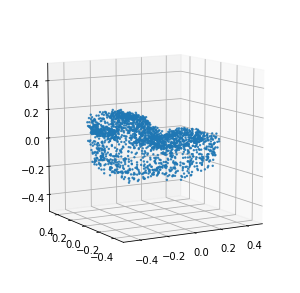

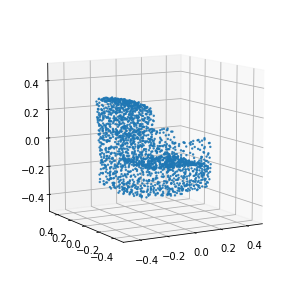

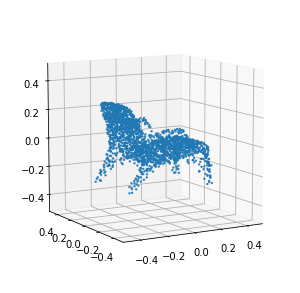

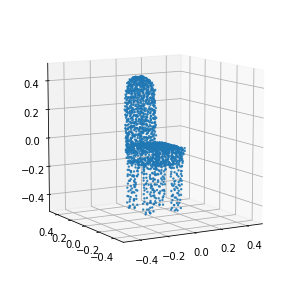

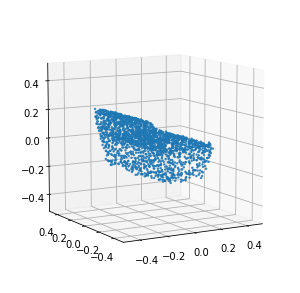

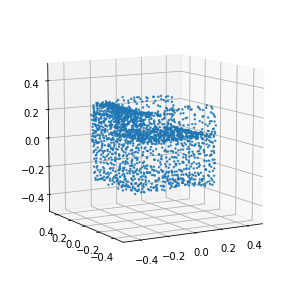

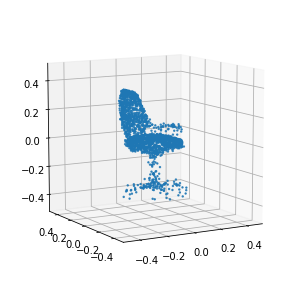

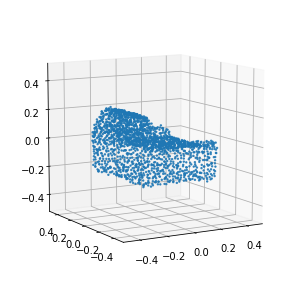

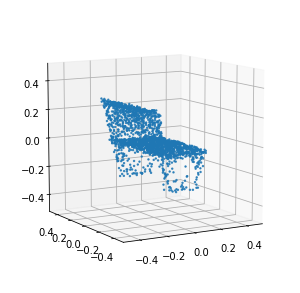

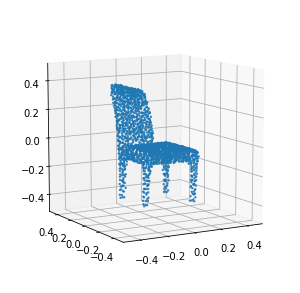

In [48]:

for i in range(NUM_TEST):
    plot_3d_point_cloud(reconstructions[i][:, 0], 
                        reconstructions[i][:, 1], 
                        reconstructions[i][:, 2], in_u_sphere=True)
